In [1]:
# make a graph that shows convergence as a function of layout trials and swap trials

# very important point to not forget
# NOTE, these layout trials are after multiple SWAP trials and through forward-backwards pass
# this means it has already gone through 2 stages of optimization and we still have large variance

# ultimate question is how much time do we need to spend on swap restarts, forward-backward passes, and layout restarts
# maybe we work from bottom up, collect data to get a fair estimate of how much time we need to spend on each?

from qiskit.transpiler import CouplingMap
from mirror_gates.pass_managers import SabreMS, QiskitLevel3
from transpile_benchy.metrics.abc_metrics import MetricInterface
from transpile_benchy.metrics.gate_counts import DepthMetric
from mirror_gates.utilities import DoNothing

In [2]:
class LayoutTrialsStdMetric(MetricInterface):
    def __init__(self):
        """Initialize the metric."""
        super().__init__(
            name="layout_trials_std", pretty_name="Layout Trial Standard Deviation"
        )

    def _construct_pass(self):
        """Return the pass associated with this metric."""
        return DoNothing()


class LayoutTrialsMetric(MetricInterface):
    def __init__(self):
        """Initialize the metric."""
        super().__init__(name="layout_trials", pretty_name="Layout Trial Costs")

    def _construct_pass(self):
        """Return the pass associated with this metric."""
        return DoNothing()

In [3]:
from transpile_benchy.library import CircuitLibrary

# library = CircuitLibrary.from_txt("../medium_circuits.txt")
library = CircuitLibrary.from_txt("iterations.txt")

In [4]:
coupling_map = CouplingMap.from_heavy_hex(5)
transpilers = [
    # QiskitLevel3(coupling_map),
    SabreMS(coupling_map, name="SABREMS", layout_trials=20)
]

metrics = [LayoutTrialsMetric(), DepthMetric(consolidate=False)]

In [5]:
from transpile_benchy.benchmark import Benchmark

# only interested in TimeMetric, is there by default
benchmark = Benchmark(
    transpilers=transpilers,
    circuit_library=library,
    metrics=metrics,
    num_runs=10,
)
benchmark.run()

Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 0.50	 | xx_plus_yy(-1.57080)
 50.00% =    1/2    	 | 1.00	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)
100.00% =    1/1    	 | 1.50	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)


Circuits from library:   0%|          | 0/4 [00:00<?, ?it/s]

Loading qft_n8 from MQTBench


Circuits from library:  25%|██▌       | 1/4 [02:01<06:05, 121.87s/it]

Loading qft_n16 from MQTBench


Circuits from library:  50%|█████     | 2/4 [06:21<06:46, 203.18s/it]

Loading qft_n32 from MQTBench


Circuits from library: 100%|██████████| 4/4 [21:41<00:00, 325.27s/it]

Loading qft_n64 from MQTBench


SABREMS-$\sqrt{\texttt{iSWAP}}$
(10, 20)


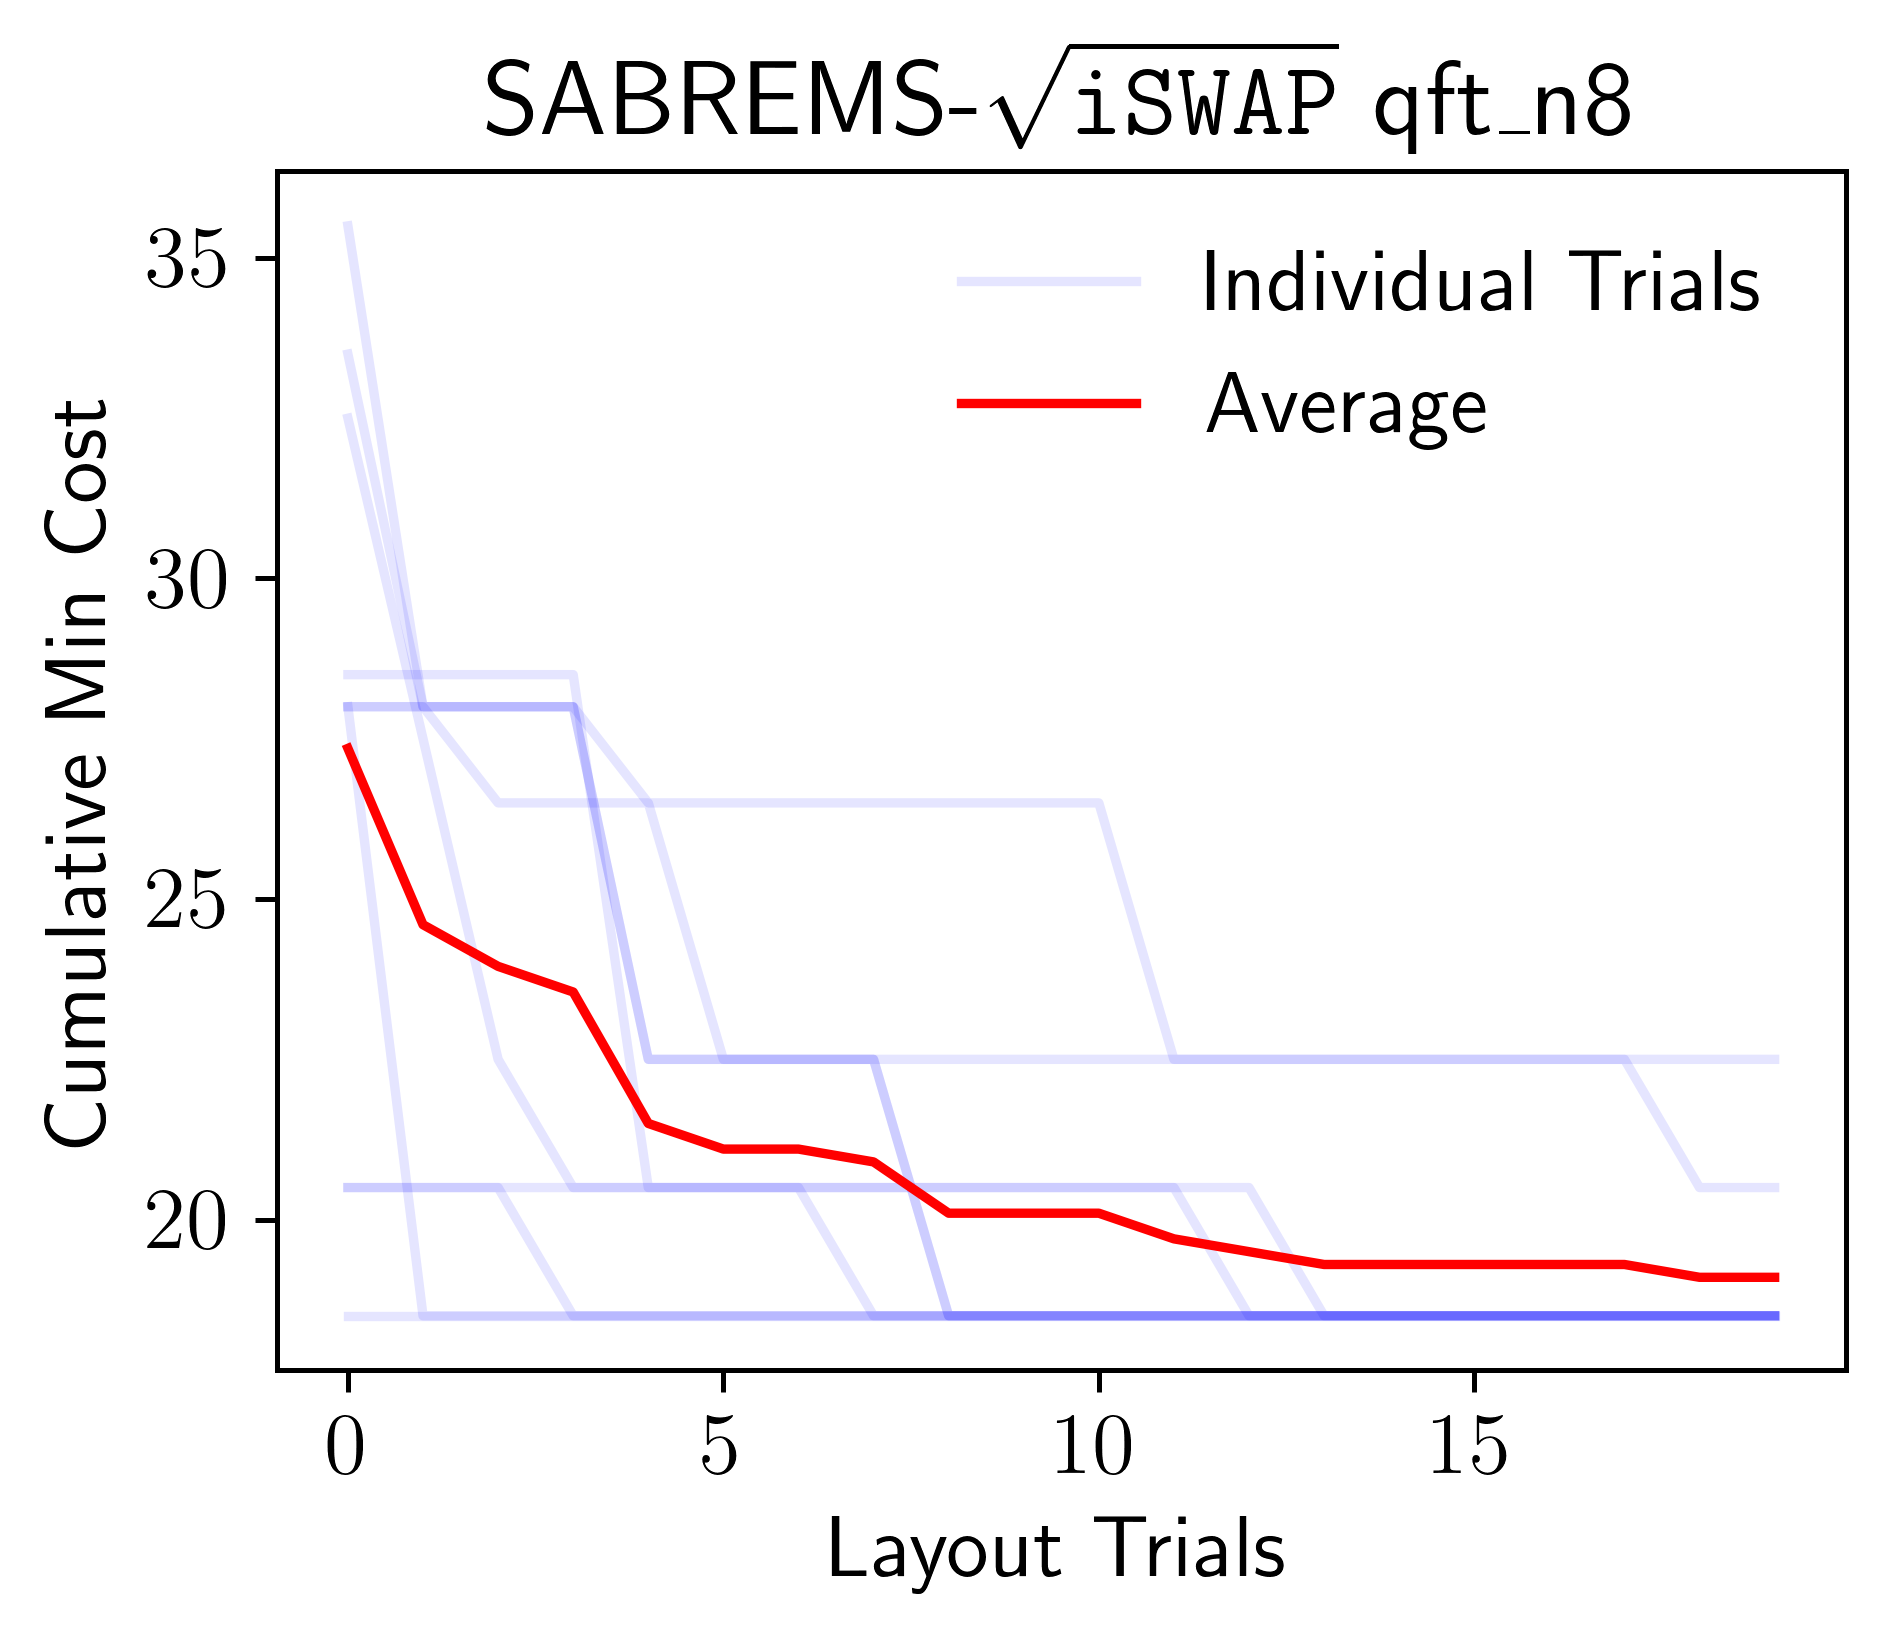

(10, 20)


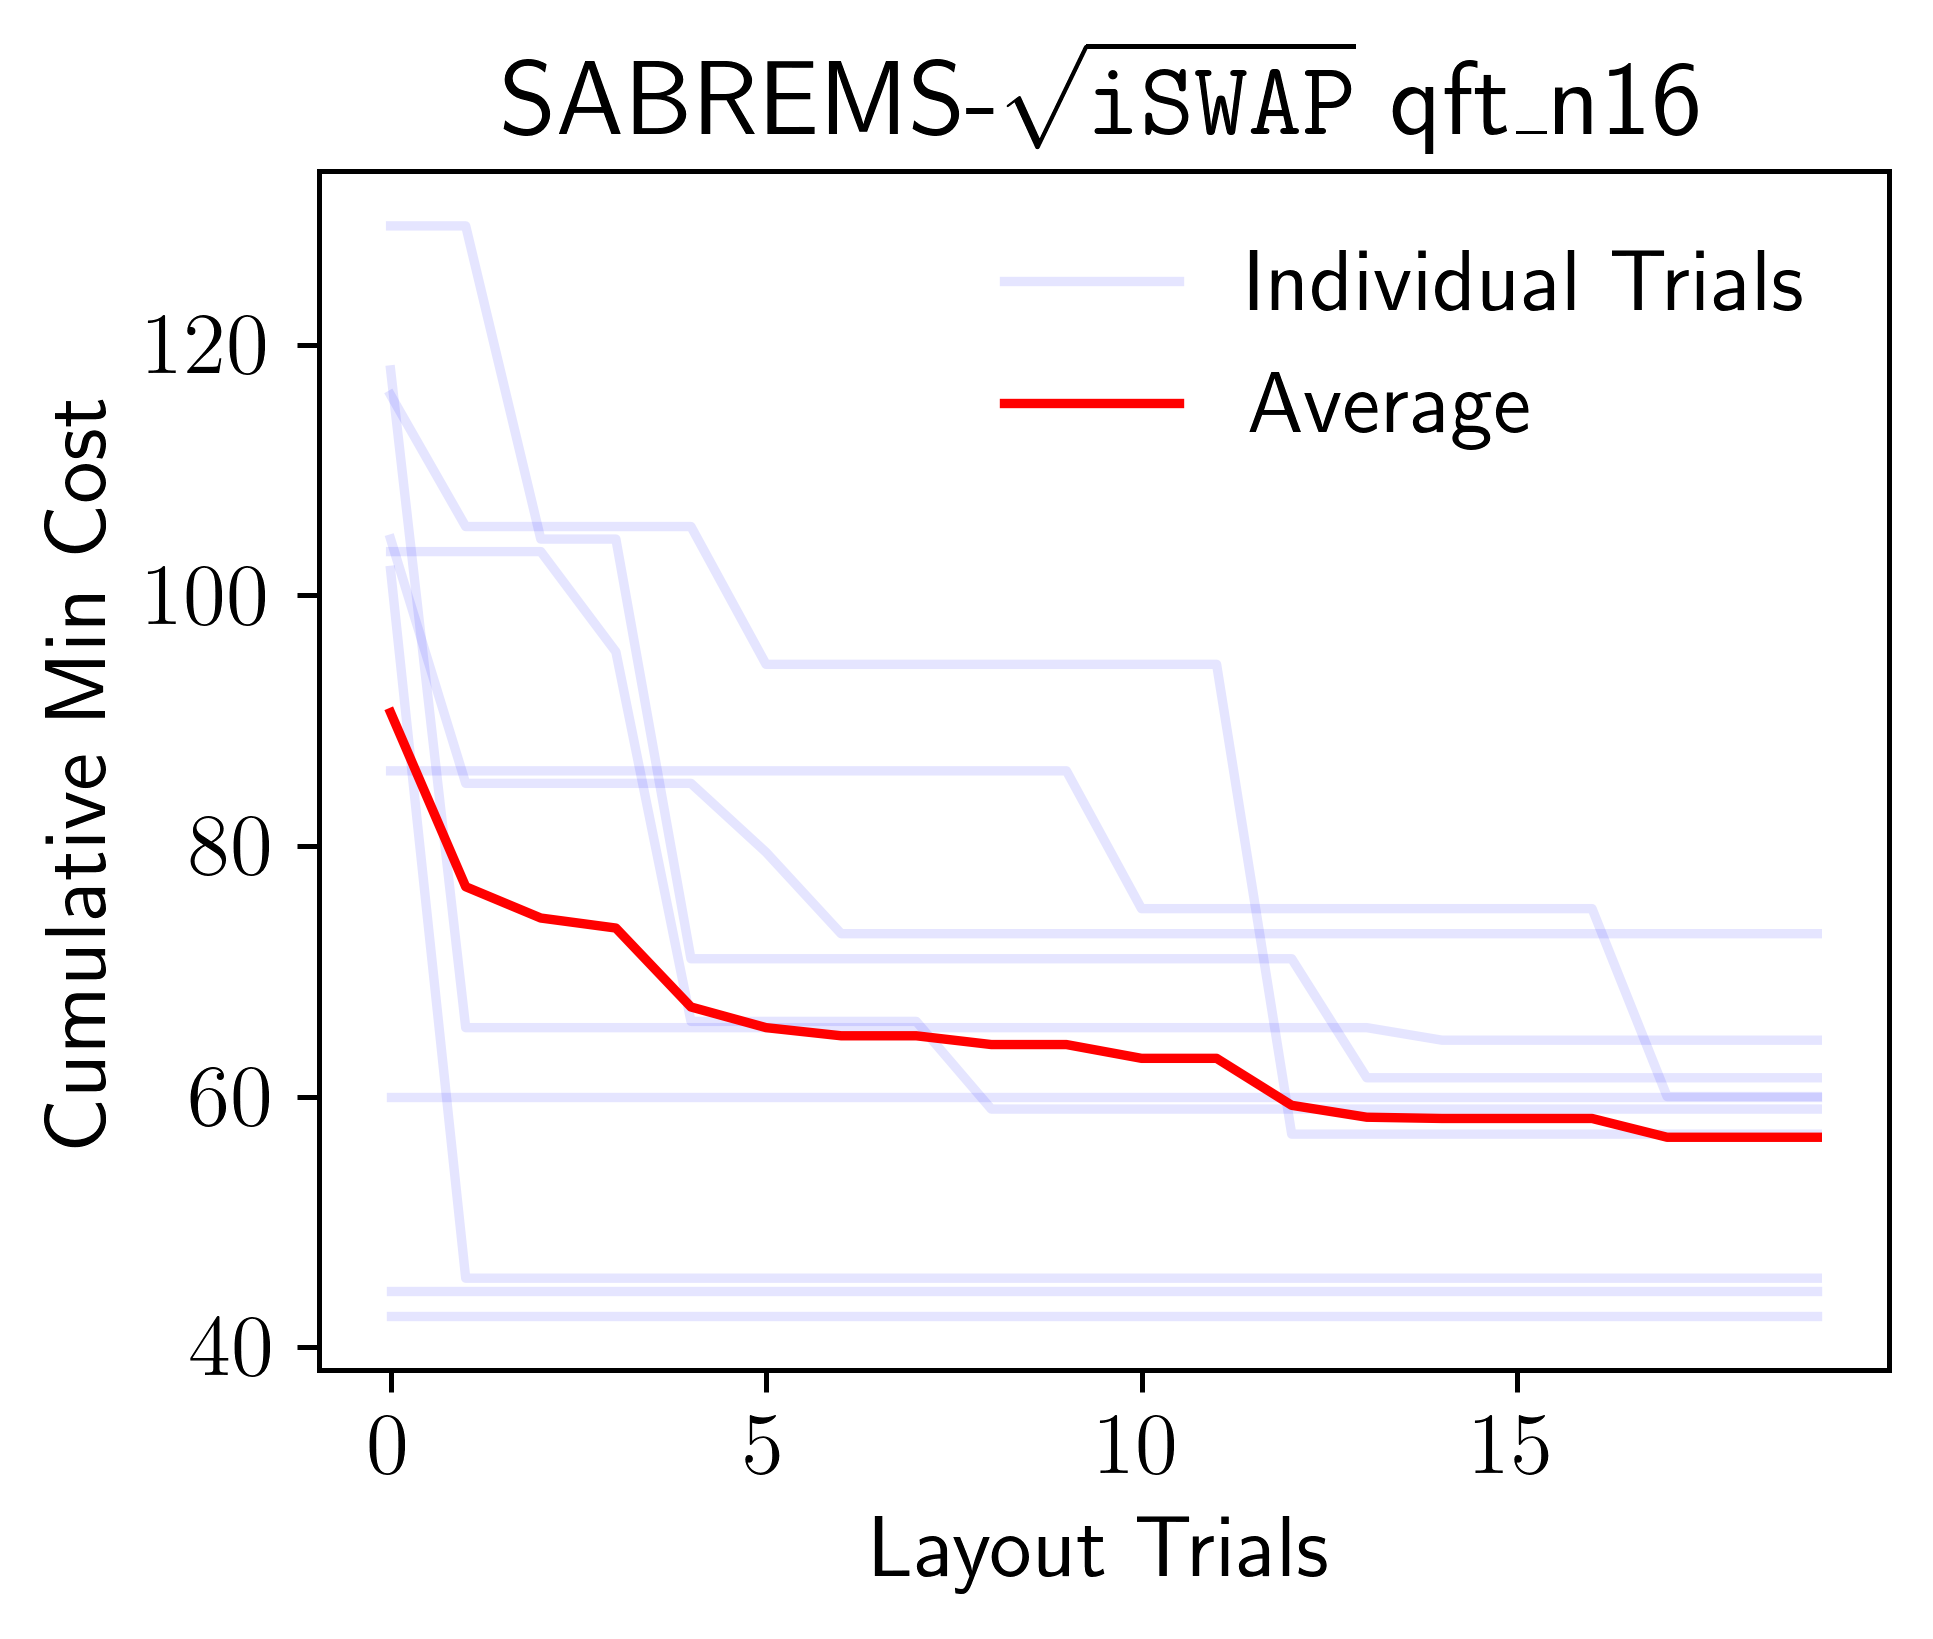

(10, 20)


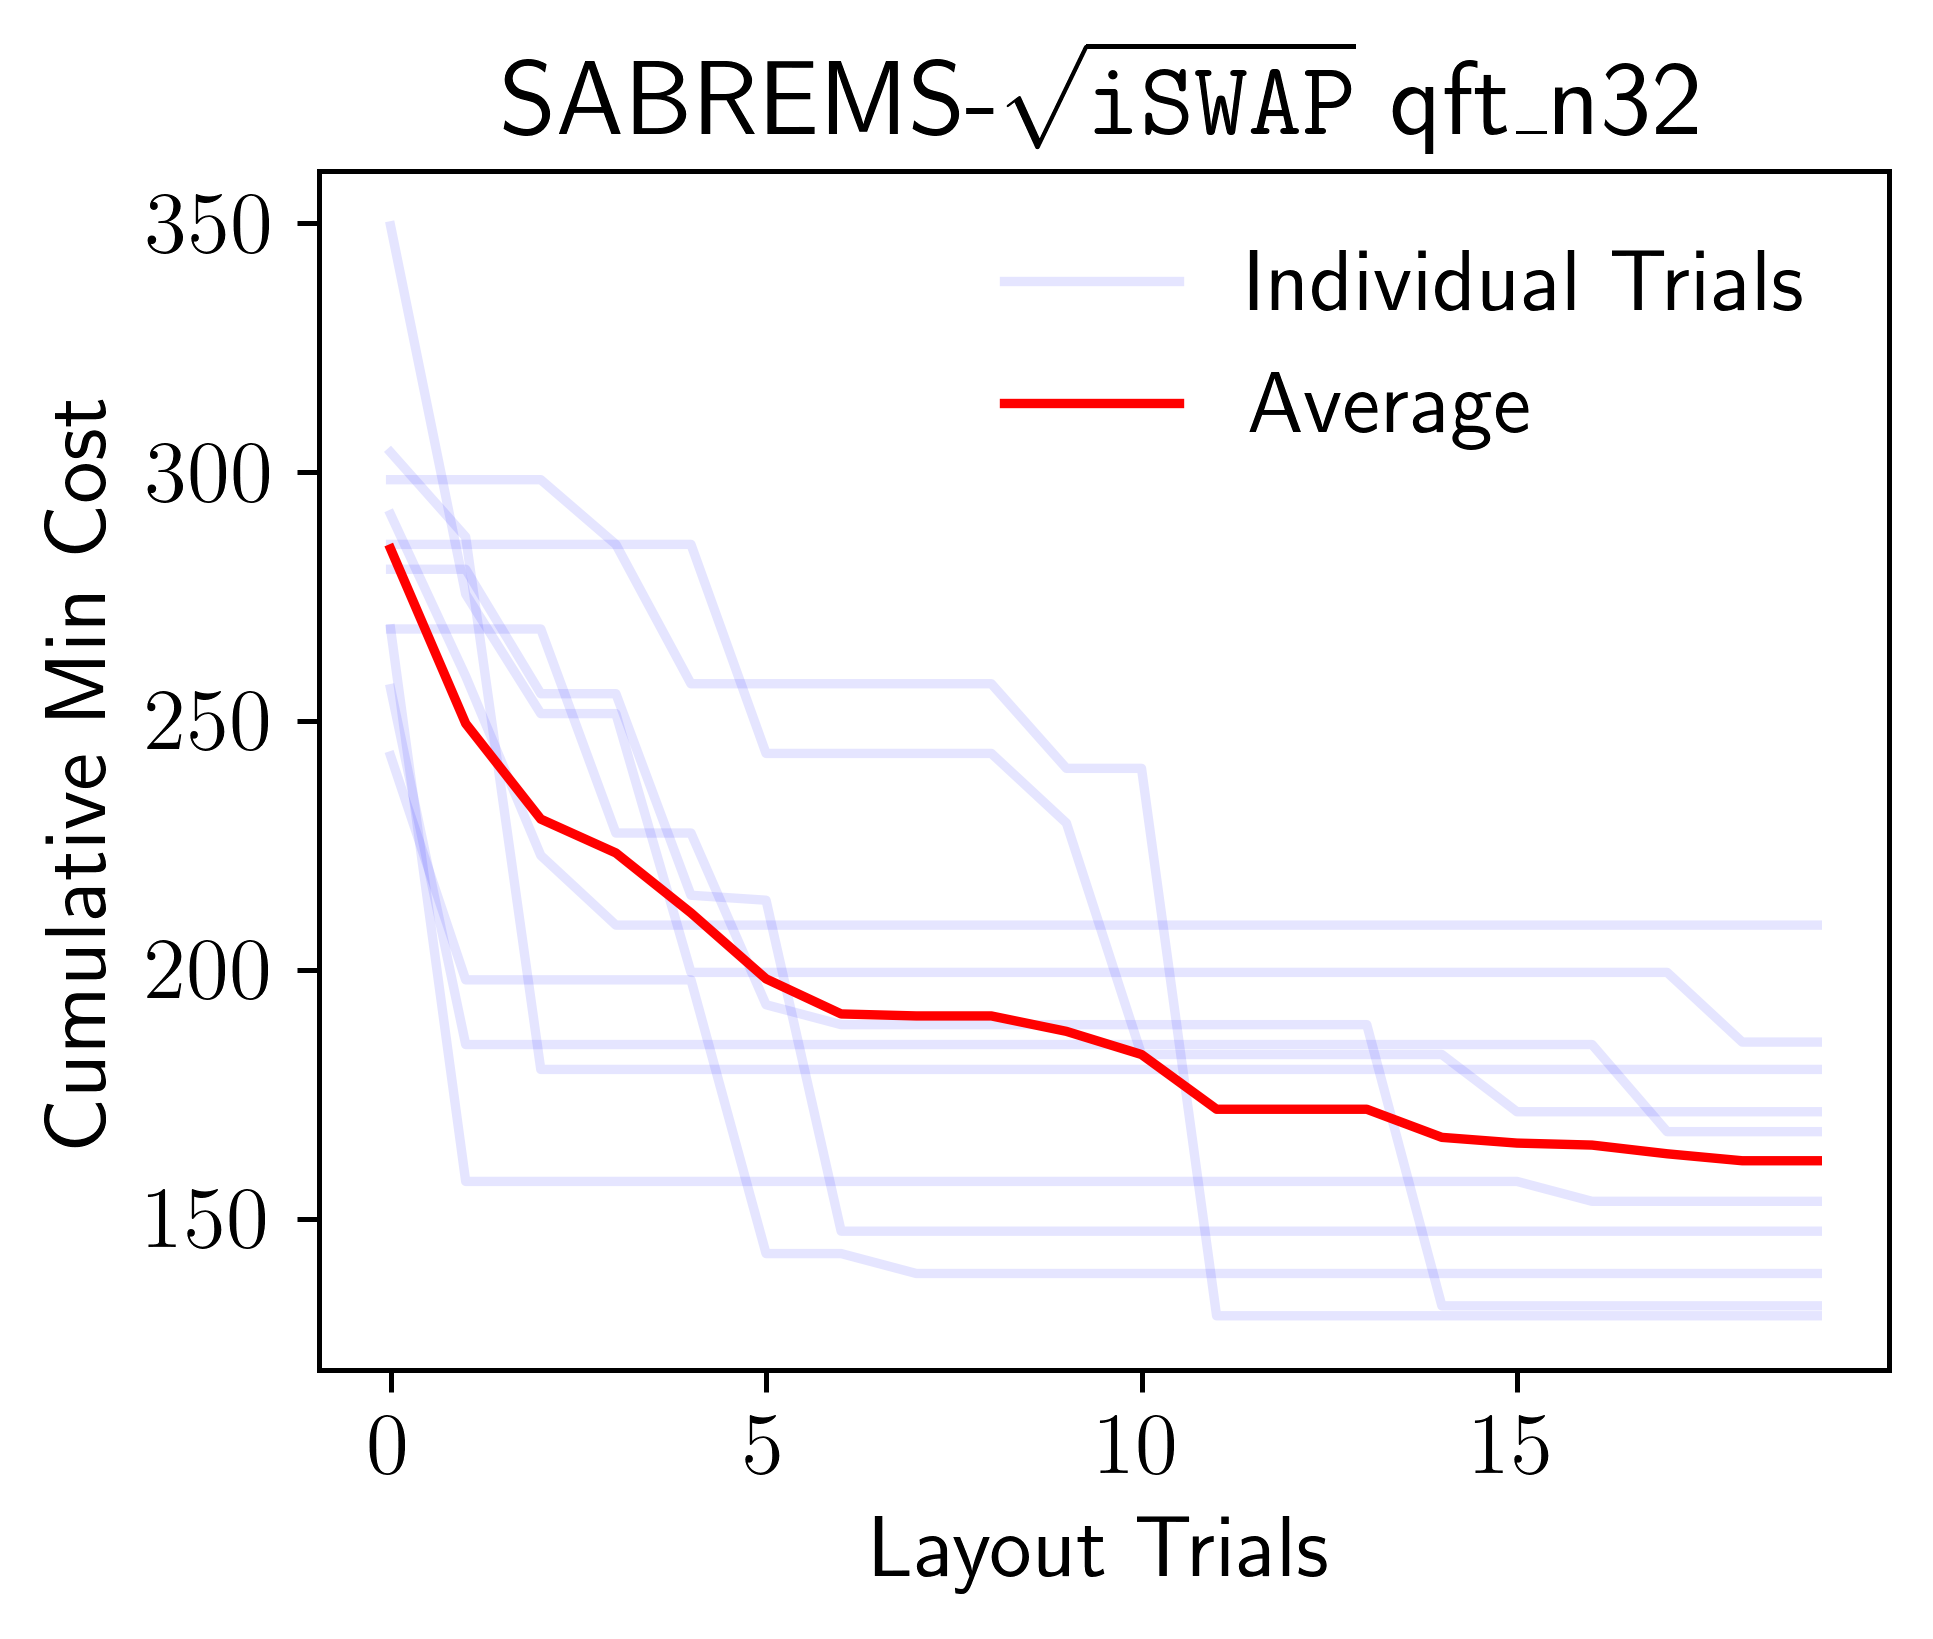

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming benchmark.metrics[0].saved_results.items() is a dictionary
# where keys are circuit names and values are lists of costs for each trial
for k, v in benchmark.metrics[0].saved_results.items():
    print(k)
    for circuit, result in v.items():
        # print(circuit)
        # print(result.data)

        # find cumulative min trial-wise
        min_trials = np.minimum.accumulate(result.data, axis=1)
        print(min_trials.shape)
        # print(min_trials)

        # average element-wise across all trials
        avg = np.mean(min_trials, axis=0)
        # print(avg)

        # plot cumulative min vs trial
        # also plot average cumulative min vs trial
        # at each trial we also want to scatter plot each individual trial,

        # plot with latex
        with plt.style.context(["ipynb", "colorsblind10"]):
            plt.rcParams["text.usetex"] = True
            for j, trials in enumerate(min_trials):
                plt.plot(
                    trials,
                    color="blue",
                    alpha=0.1,
                    label="Individual Trials" if j == 0 else None,
                )
            plt.plot(avg, color="red", label="Average")
            plt.xlabel("Layout Trials")
            plt.ylabel("Cumulative Min Cost")
            plt.title(f"{k} {circuit}")
            plt.ticklabel_format(style="plain")  # Turn off scientific notation
            plt.legend()
            plt.show()

In [7]:
# # explictly print results
# for k, v in benchmark.metrics[0].saved_results.items():
#     for circuit, result in v.items():
#         print(result.data)